In [16]:
import os

from matplotlib import pyplot as plt, animation as animation
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from pykalman import KalmanFilter

import pyedflib
from pyedflib import highlevel

import torch
from torch import nn, optim, tensor

π = np.pi

In [4]:
# Data directory (only on Nathan's machine, just for exploring)
path = 'nathan'

# This patient is in the train
patient_name = 'SC4111'

psg_path = os.path.join(path, f'{patient_name}E0-PSG.edf')
hyp_path = os.path.join(path, f'{patient_name}EC-Hypnogram.edf')

signals, signal_headers, header = highlevel.read_edf(psg_path)
hsignals, hsignal_headers, hheader = highlevel.read_edf(hyp_path)

In [5]:
# Create a dict of dicts with the label as the key and each dict including
# the index of the corresponding data in signals
# `shs` is short for 'signal_headers'
shs = dict()
for i, d in enumerate(signal_headers):
  tmp = d
  label = tmp.pop('label')
  tmp['idx'] = i
  shs[label] = tmp

shs

{'EEG Fpz-Cz': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 201.0,
  'physical_min': -204.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 0},
 'EEG Pz-Oz': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 175.0,
  'physical_min': -176.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 1},
 'EOG horizontal': {'dimension': 'uV',
  'sample_rate': 100.0,
  'sample_frequency': 100.0,
  'physical_max': 1032.0,
  'physical_min': -1035.0,
  'digital_max': 2047,
  'digital_min': -2048,
  'prefilter': 'HP:0.5Hz LP:100Hz [enhanced cassette BW]',
  'transducer': 'Ag-AgCl electrodes',
  'idx': 2},
 'Resp oro-nasal': {'dimension': '',
  'sample_rate': 1.0,
  'sample_frequency': 1.0,
  'physical_max': 204

In [6]:
hyp = hheader['annotations']
hheader

{'technician': '',
 'recording_additional': '',
 'patientname': 'Male 26yr',
 'patient_additional': '',
 'patientcode': '',
 'equipment': '',
 'admincode': '',
 'sex': 'Male',
 'startdate': datetime.datetime(1989, 5, 1, 16, 29),
 'birthdate': '',
 'gender': 'Male',
 'annotations': [[0.0, 28050.0, 'Sleep stage W'],
  [28050.0, 60.0, 'Sleep stage 1'],
  [28110.0, 60.0, 'Sleep stage W'],
  [28170.0, 180.0, 'Sleep stage 1'],
  [28350.0, 570.0, 'Sleep stage 2'],
  [28920.0, 60.0, 'Sleep stage W'],
  [28980.0, 30.0, 'Sleep stage 1'],
  [29010.0, 30.0, 'Sleep stage W'],
  [29040.0, 60.0, 'Sleep stage 1'],
  [29100.0, 720.0, 'Sleep stage 2'],
  [29820.0, 30.0, 'Sleep stage 3'],
  [29850.0, 60.0, 'Sleep stage 2'],
  [29910.0, 30.0, 'Sleep stage 3'],
  [29940.0, 60.0, 'Sleep stage 2'],
  [30000.0, 30.0, 'Sleep stage 3'],
  [30030.0, 30.0, 'Sleep stage 2'],
  [30060.0, 30.0, 'Sleep stage 3'],
  [30090.0, 90.0, 'Sleep stage 2'],
  [30180.0, 30.0, 'Sleep stage 3'],
  [30210.0, 60.0, 'Sleep stage 2'

In [7]:
# Get the timestamps of each sleep stage annotation
# and the duration of that sleep stage
timestamps = np.array([mark[0] for mark in hyp], dtype=int)
durations = np.array([mark[1] for mark in hyp], dtype=int)

# Get the labeled stages
original_labels = \
  ['Sleep stage ?', 'Movement time', 'Sleep stage W',
   'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R']
new_labels = ['?', 'm', 'w', '1', '2', '3', '4', 'r']
label_map = { old : new for old, new in zip(original_labels, new_labels)}

stages = np.array([label_map[mark[2]] for mark in hyp])

timestamps[:10], durations[:10], stages[:10]

(array([    0, 28050, 28110, 28170, 28350, 28920, 28980, 29010, 29040,
        29100]),
 array([28050,    60,    60,   180,   570,    60,    30,    30,    60,
          720]),
 array(['w', '1', 'w', '1', '2', 'w', '1', 'w', '1', '2'], dtype='<U1'))

In [8]:
# Fourier on segments of data of this length
SECONDS = 10

info = shs['EEG Fpz-Cz']
data = signals[info['idx']]
freq = info['sample_frequency']

# The total number of samples
n = len(data)

# The number of samples per segment of SECONDS length
k = samples_per_interval = int(freq * SECONDS)

# The number of segments of SECONDS length
length = n // k

# The frequencies of the Fourier coefficients
freqs = fftfreq(k, 1/freq)[: k//2]

# Get the Fourier coefficients for each segment, saving in rows
fourier = np.full((length, k//2), -np.inf)
for i in range(length):
  subset = data[k*i : k*(i+1)]
  amps = np.real(fft(subset)[: k//2])

  fourier[i] = amps

T, N = fourier.shape

# Get the indices into timestamps to find the current sleep stage
hyp_frames = np.arange(T) * SECONDS

# Get the index of the first timestamp that's less than or equal to frame
# by getting the index of the first timestamp that's greater than frame,
# then subtracting one.
hyp_idx = np.array([np.maximum(np.argmax(frame < timestamps) - 1, 0) for frame in hyp_frames])
hyp_stages = stages[hyp_idx]

# 500 Fourier coefficients... Mostly zero after 100, so keep only the first 100
top_freq_idx = 100
Tmin, Tmax = 3250, 3750
fourier = fourier[Tmin:Tmax, :top_freq_idx]
T, N = fourier.shape

T, N

(500, 100)

In [9]:
sleep_stages=  ('m', 'w', '1', '2', '3', '4', 'r')
# dim_x doesn't necessarily need to be the same as num_stages
num_stages = len(sleep_stages)
dim_x = num_stages
dim_z = N

# Init
kf = KalmanFilter(n_dim_state=dim_x, n_dim_obs=dim_z)

# Fit to fourier data with expectation maximization
kf.em(fourier)

In [10]:
# Predict the states for the fourier data
states, covs = kf.smooth(fourier)

In [11]:
# number of samples x dim_x
states.shape

(500, 7)

In [12]:
# Sample of states
np.round(states, 1)[:10]

array([[  -47.5,  1074. ,   286. ,  -539.6,  2609.4, -1071.5, -1126.3],
       [ -531.3,   623.5,   -36.8,  -579.7,  1404.1, -1447.3,  -369.3],
       [ -682.8,   354.6,    30.3,  -179.3,   580.9, -1717. ,   497.4],
       [ -751.1,   163.5,  -185.4,  -439.5,    10.1, -1995.2,   480.9],
       [ -912.5,   -72.5,  -505.6,  -790.3,  -812. , -2455.8,   405.8],
       [-1080.2,  -212.3,  -569.4, -1149.6, -1476.2, -2336.9,   487. ],
       [-1232.3,  -238.3,  -618.7, -1584.4,  -927.4, -1978.9,  -110.8],
       [-1258.2,  -239.2,  -234.7, -1421.8,  -937. , -1264.6,   165.5],
       [-1244.6,  -246.6,   -34.5, -1263. ,  -784.6, -1153.9,    30.7],
       [-1208.7,  -102.1,   145.8, -1451.4,   -81.4,  -888.5,    56.9]])

In [106]:
# Sleep stage labels
labels = hyp_stages[Tmin:Tmax]
labels

array(['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3',
       '3', '3', '3', '2', '2', '2', '3', '3', '3', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '3', '3', '3', '2', '2', '2', '2', '2',
       '2', '3', '3', '3', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', 'r', 'r', 'r', 'r', 'r',
       'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r

In [107]:
# Create an ordinal encoding of sleep stages to use with the linear layer and cross-entropy loss
enc = OrdinalEncoder(dtype=int)
enc.fit(np.array([sleep_stages]).T)
ordinal_labels = enc.transform(labels[:, np.newaxis]).squeeze()
all_labels = enc.transform(np.array([sleep_stages]).T).squeeze()
ordinal_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

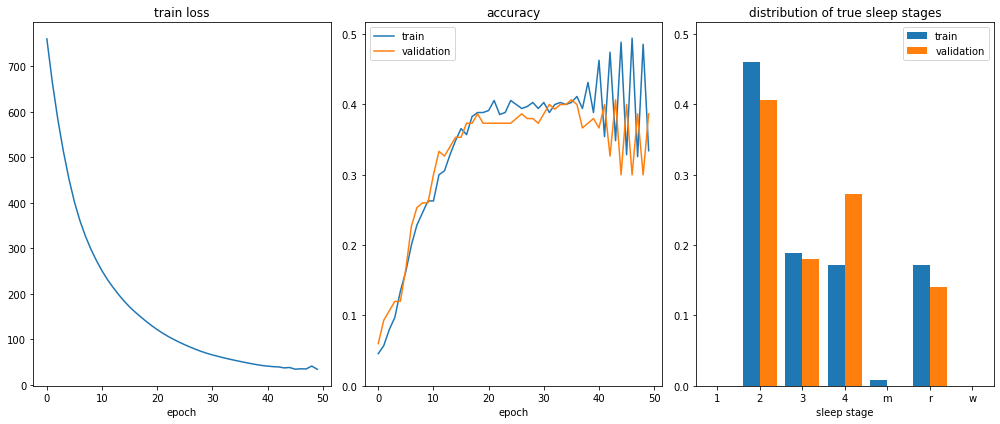

In [119]:
# Init linear layer and training procedure
torch.manual_seed(42)
linear = nn.Linear(dim_x, num_stages, dtype=float)
lr = 1e-4
opt = optim.SGD(params=linear.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
EPOCHS = 50

# Train-validation split
val_size = 0.3
train_states, val_states, train_labels, val_labels = \
  map(tensor, train_test_split(states, ordinal_labels, test_size=val_size, random_state=42))

# Record losses and accuracies
losses = np.full(EPOCHS, np.inf)
train_accs = np.full(EPOCHS, - np.inf)
val_accs = np.full(EPOCHS, - np.inf)

for i in range(EPOCHS):
  # Run states through linear layer
  train_outputs = linear(train_states)

  # Backprop through linear layer
  loss = criterion(train_outputs, train_labels)
  losses[i] = loss.item()
  loss.backward()
  opt.step()
  opt.zero_grad()

  # Get accuracy on train set
  train_preds = torch.argmax(train_outputs, axis=1)
  acc = accuracy_score(train_labels, train_preds)
  train_accs[i] = acc

  # Get accuracy on validation set
  val_outputs = linear(val_states)
  val_preds = torch.argmax(val_outputs, axis=1)
  acc = accuracy_score(val_labels, val_preds)
  val_accs[i] = acc

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

### Loss
ax = axs[0]
ax.plot(losses)
ax.set_title('train loss')
ax.set_xlabel('epoch')

### Accuracy
ax = axs[1]
ax.plot(train_accs, label='train')
ax.plot(val_accs, label='validation')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.set_ylim(0)
ax.legend()

### Distribution of true sleep stages
ax = axs[2]
# Number of occurrences of sleep stages
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)

# Proportions of each label
train_props = train_counts / np.sum(train_counts)
val_props = val_counts / np.sum(val_counts)

# PLot
width = 0.4
ax.bar(unique_train_labels - width/2, train_props, width=width, label='train')
ax.bar(unique_val_labels + width/2, val_props, width=width, label='validation')

ax.set_title('distribution of true sleep stages')
ax.set_xlabel('sleep stage')
ax.legend()
ax.set_xticks(all_labels, sleep_stages)
ax.set_xlim(-1/2, num_stages - 1/2)

# Share y axes between accuracy and distribution plots
ax.sharey(axs[1])

fig.tight_layout()
fig.show()

The training loss seems to approximately converge to a minimum, and the training and validation accuracy reach a maximum and then oscillate. However, a look at the distribution of true labels reveals that the model isn't doing any better than guessing the most common sleep state.

In [ ]:
# TODO: train Kalman, then try to predict next states/observations
# TODO: train Kalman and linear on one person, then run Kalman on other person and run through linear